# Diversipy Tutorial

This tutorial will walk you through using some of the main functionalities of the `Diversipy` package.

`Diversipy` leverages **_magnitude_** (i.e. effective size) as a **metric for measuring the diversity of metric spaces**.

In particular, `Diversipy` focuses on **comparing** magnitude & diversity across multiple spaces. See our `Magnipy` tutorial for advanced magnitude functionality with one metric space (`magnipy_tutorial.ipynb`).

### Importing Packages and Datasets
Before we begin, we must import the packages required for our functionality. Please ensure that you have activated your virtual environment and installed the dependencies using poetry before this step (see **Dependencies** in the README).

In [1]:
# Import statements for external packages
from importlib import reload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# Import from magnipy repo
import magnipy
reload(magnipy)
from magnipy.diversipy import Diversipy
from magnipy.utils.datasets import sample_points_gaussian, sample_points_gaussian_2, sample_points_square, hawkes_process
from magnipy.utils.plots import plot_points
from tutorial_data import *

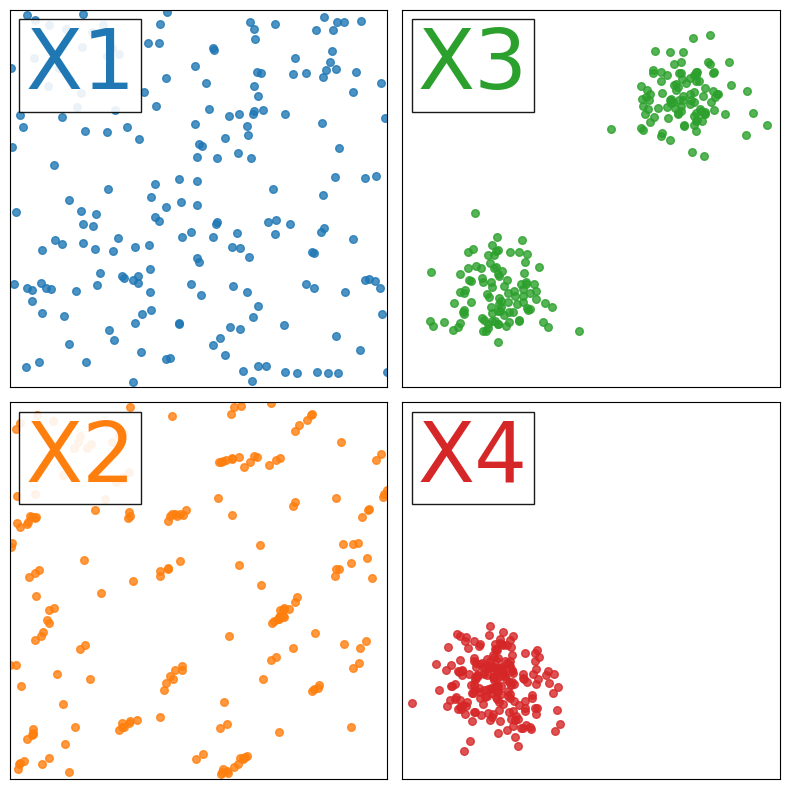

In [2]:
# Grab our example datasets
X1, X2, X3, X4 = get_Xs()
plot_spaces(X1, X2, X3, X4)

Intuitively, which of the above spaces would you consider the most _diverse_? The least diverse?

#### How do we define diversity?

Diversity is a difficult notion to define precisely, but it is governed by several **axioms** that are widely agreed upon. See our paper ([Metric Space Magnitude for Evaluating the Diversity of Latent Representations](https://arxiv.org/abs/2311.16054)) for further discussion of diversity desiderata.

#### How do we _measure_ diversity?

We propose **magnitude** - which measures the effective number of distinct points at at a distance scale **t** - as a fitting solution for quantifying diversity. Magnitude functions intrinsically satisfy the aforementioned diversity axioms and outperform other leading metrics (e.g. average similarity) that fail to accurately detect differences in diversity between datasets.

### Computing Magnitude Functions

We initialize a Diversipy object with the spaces (**Xs**) that we want to compare and label them with a list of **names**.

There are many other parameters we can pass to the Diversipy object to customize its functionality. For example, the **metric** parameter allows you to choose which distance metric to use, with the default being Euclidean. We will highlight a few of these parameters, but please see `diversipy.py` for a complete list.

In [3]:
# Initializing Diversipy instance
Xs = [X1, X2, X3, X4]
names = ["X1 (Uniform)", "X2 (Slightly Clustered)", "X3 (Two Gaussians)", "X4 (One Gaussian)"]
div = Diversipy(Xs = Xs, names=names)

In [12]:
# Computing magnitude
mag_df, ts = div.get_magnitude_functions()
show_magnitude_function(mag_df, ts)


t 	X1 	X2 	X3 	X4
0.00 	1.00 	1.00 	1.00 	1.00
2.44 	8.46 	8.05 	4.68 	2.58
4.88 	21.74 	20.19 	9.06 	4.74
7.33 	39.12 	34.93 	14.00 	7.41
9.77 	58.20 	49.57 	19.50 	10.55
12.21 	76.85 	62.58 	25.46 	14.08
14.65 	93.77 	73.57 	31.73 	17.96
17.09 	108.50 	82.73 	38.20 	22.12
19.54 	121.03 	90.41 	44.76 	26.51
21.98 	131.59 	96.96 	51.35 	31.09
24.42 	140.44 	102.63 	57.88 	35.79
26.86 	147.88 	107.62 	64.32 	40.58
29.30 	154.15 	112.09 	70.62 	45.41
31.75 	159.44 	116.13 	76.74 	50.24
34.19 	163.94 	119.83 	82.67 	55.05
36.63 	167.78 	123.24 	88.37 	59.81
39.07 	171.07 	126.42 	93.85 	64.49
41.51 	173.91 	129.38 	99.08 	69.08
43.95 	176.37 	132.16 	104.08 	73.55
46.40 	178.51 	134.77 	108.83 	77.91
48.84 	180.38 	137.24 	113.34 	82.14
51.28 	182.02 	139.58 	117.62 	86.23
53.72 	183.46 	141.79 	121.67 	90.19
56.16 	184.74 	143.88 	125.49 	94.01
58.61 	185.88 	145.88 	129.11 	97.69
61.05 	186.89 	147.77 	132.52 	101.24
63.49 	187.79 	149.57 	135.74 	104.65
65.93 	188.61 	151.29 	138.77 	1

### Defining the Evaluation Interval

**In order to effectively compare diversity between spaces, we must use the same evaluation interval.** There are two main of choosing a common evaluation interval.

**#1: Automatically with Diversipy (shown above):**

1. For each magnitude function, we calculate the **convergence scale**: the scaling factor at which 95% of points are considered _distinct_ (i.e. magnitude = 0.95 * cardinality).
    - This percentage can be customized via Diversipy's **target_prop** parameter.
2. We take the median of the convergence scales for all spaces as the end of our evaluation interval.
    - Instead of the median, the desired quantile can be customized via Diversipy's **q** parameter.

Common Evaluation Interval: 0.0 to 70.82


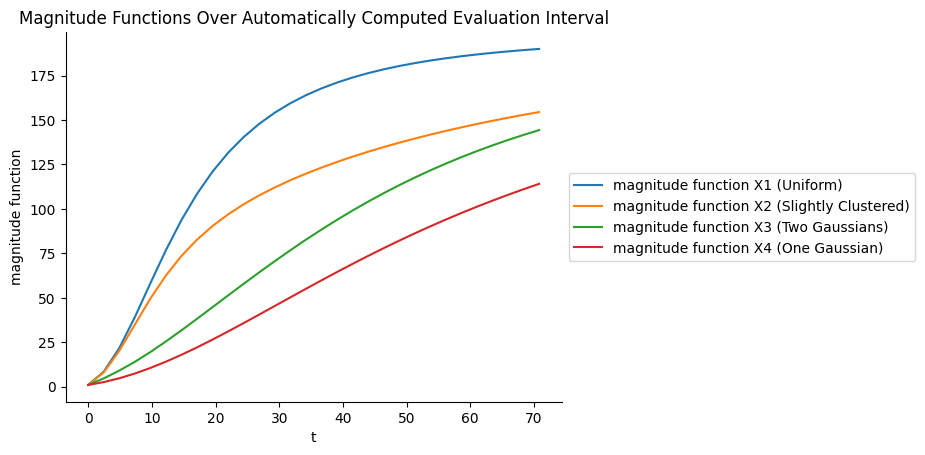

In [13]:
# Plotting magnitude functions
div.plot_magnitude_functions()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Magnitude Functions Over Automatically Computed Evaluation Interval")
# Evaluation interval computed automatically by Diversipy
print(f'Common Evaluation Interval: {ts[0]} to {ts[-1]:.2f}')

**#2 Using a Reference Space's Evaluation Interval**

We can also choose to use one metric space as our reference simply by passing a the index of the desired reference space in **Xs** to the Diversipy object via the parameter **ref_space.**

We demonstrate this method below, using X1 (index = 0) as our reference space.

Reference Evaluation Interval: 0.0 to 70.82


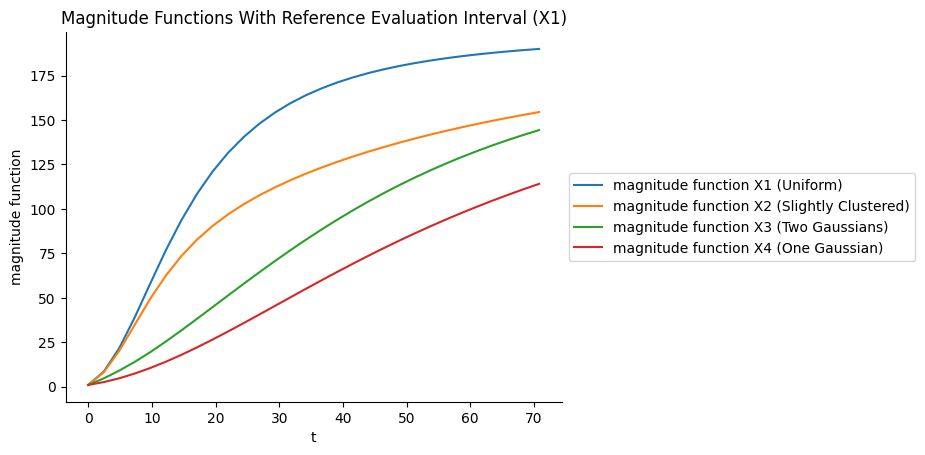

In [14]:
# Redefining Diversipy with reference space
div = Diversipy(Xs = Xs, names=names, ref_space=0)
# Computing magnitude
mag_df, ts = div.get_magnitude_functions()
# Plotting magnitude functions
div.plot_magnitude_functions()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Magnitude Functions With Reference Evaluation Interval (X1)")
# Showing common evaluation interval
print(f'Reference Evaluation Interval: {ts[0]} to {ts[-1]:.2f}')

Notice how the evaluation interval changed from [0,207] to [0,69].

We will continue on with the rest of the tutorial using the reference evaluation interval (2nd method), as was used in the accompanying paper.

### Intrinsic Diversity: **MagArea**

We define the concept of **MagArea** for a space as the area underneath its magnitude function, which we use to define a space's intrinsic diversity. The higher the MagArea, the more diverse the space.

**Check Your Understanding:**

Based on the magnitude functions plotted above (and your first instinct about the spaces themselves), which space would you expect to have the highest MagArea (intrinsic diversity)? The lowest?

In [8]:
# Computing MagArea
mag_areas = div.MagAreas()
print("MagArea Values:")
for idx in range(0, len(mag_areas)):
    print(f'{names[idx][0:2]}: {mag_areas[idx]:.2f} \t ')

MagArea Values:
X1: 139.91 	 
X2: 107.27 	 
X3: 79.78 	 
X4: 56.61 	 


Do these values confirm what you expected?

### Comparing Diversity: **MagDiff**

Further, we can conduct more detailed comparisons by computing **MagDiff**, the area between two magnitude functions, as a measure of dissimilarity.

#### Pairwise Comparison

By default, we compute the pairwise MagDiff between each of our spaces, resulting in a comparison matrix. In the visualization below, the colorbar represents the the MagDiff values computed between each pair of datasets.

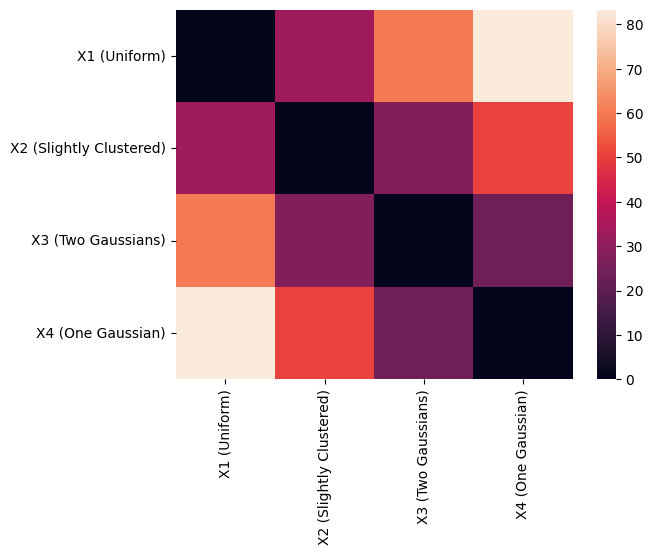

In [9]:
# Compute pairwise MagDiff
diffs = div.MagDiffs()
# Plot pairwise MagDiffs
div.plot_MagDiffs_heatmap()

**Check Your Understanding:**

1. Notice how the MagDiff comparing the a space to itself is 0, i.e. there is no difference in diversity.

2. Also notice how the MagDiff between X1 (the most diverse) and X4 (the least diverse) has the highest value, i.e. lightest color.

#### Comparison to Reference Datset

You can also compare all spaces against one reference space (recall that we already set our reference space as X1). To do compute MagDiff in this way, set parameter **pairwise=False**.

**Check Your Understanding:**

What would you expect the MagDiff between X1 and the reference space (also X1) to be? Which space would you expect to have the largest MagDiff in relation to the reference space?

In [10]:
# Compute MagDiff with reference space
diffs = div.MagDiffs(pairwise=False)
print("MagDiff Values:")
for idx in range(0, len(diffs)):
    print(f'{names[idx][0:2]}: {diffs[idx]:.2f} \t ')


MagDiff Values:
X1: 0.00 	 
X2: 32.64 	 
X3: 60.12 	 
X4: 83.30 	 


This reference-dataset approach reduces computation time and is particularly usefull for detecting **mode collapse** and **mode dropping**, two commonly faced problems in machine learning related to a decrease in output diversity as compared to the input/training data. Check out the `mode-dropping.ipynb` notebook for more information on this use case.

![Mode Dropping and Collapse](./assets/mode-collapse-mode-dropping.png)
*Figure from [Metric Space Magnitude for Evaluating the Diversity of Latent Representations](https://arxiv.org/abs/2311.16054).*


###  Nice work!

This concludes the Diversipy tutorial.

#### Wanting to zoom in more?

Note that some of the underlying functionality of the Diversipy class is conducted by the Magnipy class, which is the main class that executes magnitude calculations for a single dataset. Please see the Magnipy tutorial (`magnipy_tutorial.ipynb`) to zoom in how these are conducted and additional applications of magnitude.